**Features**

1. Link Prediction for recommending Pins (Images) to Users
2. Change convolutional (VGG) and Word2Vec based image and text feature extraction with CLIP multimodal unified embeddings.
3. Introduce knowledge distillation with CLIP as teacher model and PinSage as student model.
4. Compare 3 models
 1. PinSage with orginal convolutional embedding
 2. PinSage + CLIP's Multimodal embedding
 3. PinSage with CLIP's Multimodal embedding (Distillation Loss)


**Dataset**
Pinterest ICCV (contains images associated to Pinterest users’ who have “pinned” them.)

*   46k Users / Boards
*   1.5M Images / Items
*   2.5M User-Item interactions

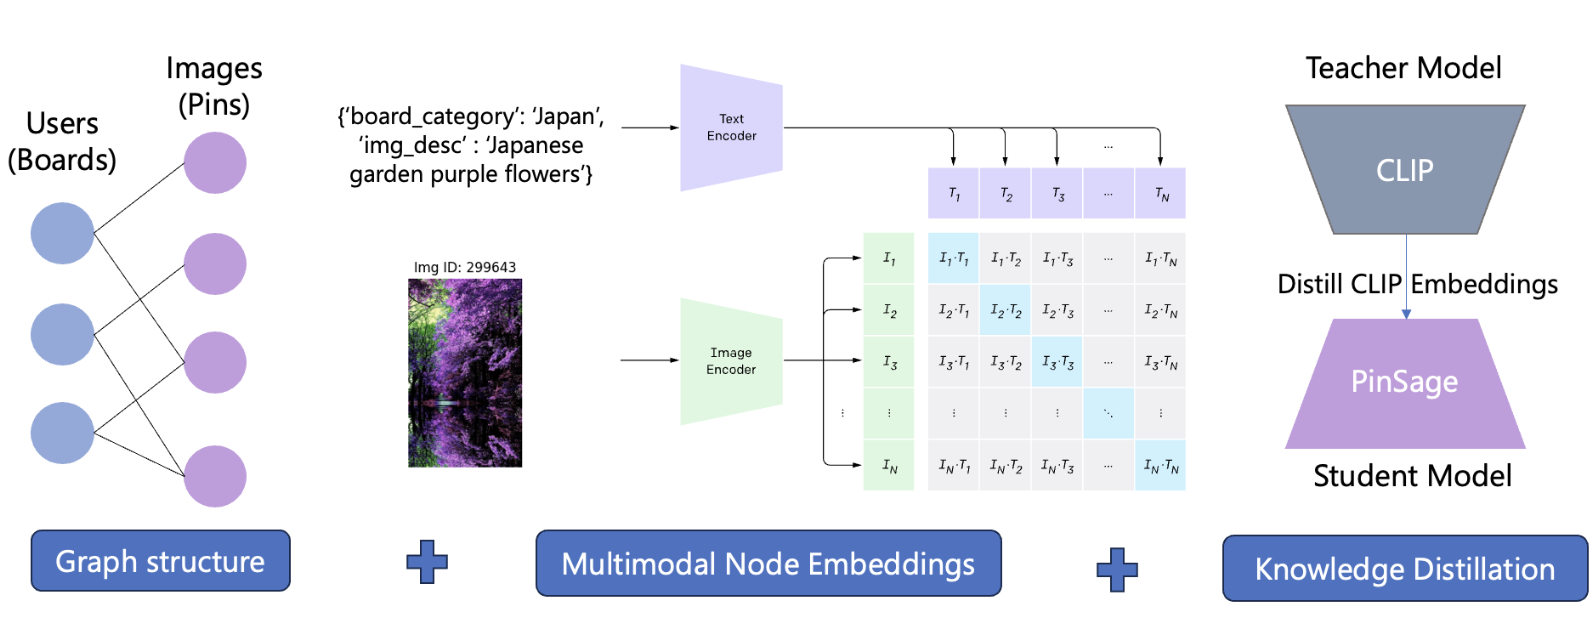

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch==2.1.0

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu121
True


In [ ]:
! pip install  dgl -f https://data.dgl.ai/wheels/torch-2.1/cu121/repo.html
! pip install torchtext==0.16.0
! pip install pandas==1.5.0
! pip install dask==2022.1.1

In [ ]:
%cd /content/drive/MyDrive/CS_519_Project/CLIPSage/

/content/drive/MyDrive/CS_519_Project/CLIPSage


In [ ]:
!python3 -m pip install pymongo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 29.9 MB/s eta 0:00:00


# Data Cleaning and Exploratory Data Analysis

In [ ]:
import bson
import pandas as pd
from natsort import natsorted

In [ ]:
# Step 1: Load Categories from categories.txt
categories_txt_filepath = '/content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_iccv/categories.txt'
cate_id_to_name = {}

with open(categories_txt_filepath, 'r') as f:
    for idx, line in enumerate(f):
        category_name = line.strip()
        cate_id_to_name[idx] = category_name

# Step 2: Load board_id and cate_id from subset_iccv_board_cate.bson
cate_bson_filepath = '/content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_iccv/subset_iccv_board_cate.bson'
board_to_category = {}

with open(cate_bson_filepath, 'rb') as file:
    cate_bson_data = file.read()
    for obj in bson.decode_all(cate_bson_data):
        board_id = obj['board_id']
        cate_id = obj.get('cate_id')
        category_name = cate_id_to_name.get(int(cate_id) - 1)
        board_to_category[board_id] = category_name

# Step 3: Load pin_id to img_url mapping from subset_iccv_pin_im.bson and assign unique img_id
pin_im_bson_filepath = '/content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_iccv/subset_iccv_pin_im.bson'
pin_to_img = {}
img_to_id = {}
img_id_iter = 0

with open(pin_im_bson_filepath, 'rb') as file:
    pin_im_bson_data = file.read()
    for obj in bson.decode_all(pin_im_bson_data):
        pin_id = obj['pin_id']
        img_url = obj['im_url']  # Replace 'im_url' with the actual field name if different
        pin_to_img[pin_id] = img_url

# Assign a unique `img_id` to each `img_url` in natsorted order
for img_url in natsorted(pin_to_img.values()):
    if img_url not in img_to_id:
        img_to_id[img_url] = img_id_iter
        img_id_iter += 1

# Step 4: Load board_id and pin_id from subset_iccv_board_pins.bson and combine with category_name and img_id
pins_bson_filepath = '/content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_iccv/subset_iccv_board_pins.bson'
dataset = []

with open(pins_bson_filepath, 'rb') as file:
    pins_bson_data = file.read()
    for obj in bson.decode_all(pins_bson_data):
        board_id = obj['board_id']
        pins = obj['pins']  # List of pin_ids

        # Get category name using board_id
        category_name = board_to_category.get(board_id)

        # Create a record for each pin
        for pin_id in pins:

              img_url = pin_to_img.get(pin_id)
              img_id = img_to_id.get(img_url, -1)  # Get img_id, or -1 if img_url not found

              dataset.append({
                  'board_id': board_id,
                  'pin_id': pin_id,
                  'category_name': category_name,
                  'img_id': img_id,
                  'img_url': img_url
              })

# Step 5: Convert to DataFrame
df = pd.DataFrame(dataset)

# Display two rows for each category
sampled_df = df.groupby('category_name').head(2)
print(sampled_df)

# Optionally, save the sampled DataFrame to CSV
output_filepath = '/content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_iccv/board_pin_category_imgid_dataset.csv'
df.to_csv(output_filepath, index=False)
print(f"dataset saved to {output_filepath}")


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_iccv/board_pin_category_imgid_dataset.csv')
df.head(10)

,board_id,pin_id,category_name,img_id,img_url
0,119134421331766936,119134352618674646,Android,406987,https://s-media-cache-ak0.pinimg.com/originals...
1,119134421331766936,119134352618662252,Android,5547,https://s-media-cache-ak0.pinimg.com/originals...
2,119134421331766936,119134352618656367,Android,529689,https://s-media-cache-ak0.pinimg.com/originals...
3,119134421331766936,119134352618650870,Android,438475,https://s-media-cache-ak0.pinimg.com/originals...
4,119134421331766936,119134352618446617,Android,398231,https://s-media-cache-ak0.pinimg.com/originals...
5,119134421331766936,119134352618440692,Android,477138,https://s-media-cache-ak0.pinimg.com/originals...
6,119134421331766936,119134352618427540,Android,729864,https://s-media-cache-ak0.pinimg.com/originals...
7,119134421331766936,119134352618423757,Android,688537,https://s-media-cache-ak0.pinimg.com/originals...
8,119134421331766936,119134352618416078,Android,449024,https://s-media-cache-ak0.pinimg.com/originals...
9,119134421331766936,119134352613427201,Android,214438,https://s-media-cache-ak0.pinimg.com/originals...


In [ ]:
df['board_id'] = pd.to_numeric(df['board_id'], errors='coerce')
df['pin_id'] = pd.to_numeric(df['pin_id'], errors='coerce')

# Drop rows where either 'board_id' or 'pin_id' is NaN (i.e., where they were non-numeric)
df = df.dropna(subset=['board_id', 'pin_id'])

# Reset the DataFrame index after dropping rows
df = df.reset_index(drop=True)




In [ ]:
print("Number of Users/Boards: ",df['board_id'].unique().shape[0])
print("Number of Images/Pins: ",df['pin_id'].unique().shape[0])
print("Number of User-Item Interactions: ",df.shape[0])

Number of Users/Boards:  46000
Number of Images/Pins:  1596968
Number of User-Item Interactions:  2533880


In [ ]:
df['category_name'][42355]

'Boho Chic'

In [ ]:
# !python download_images.py

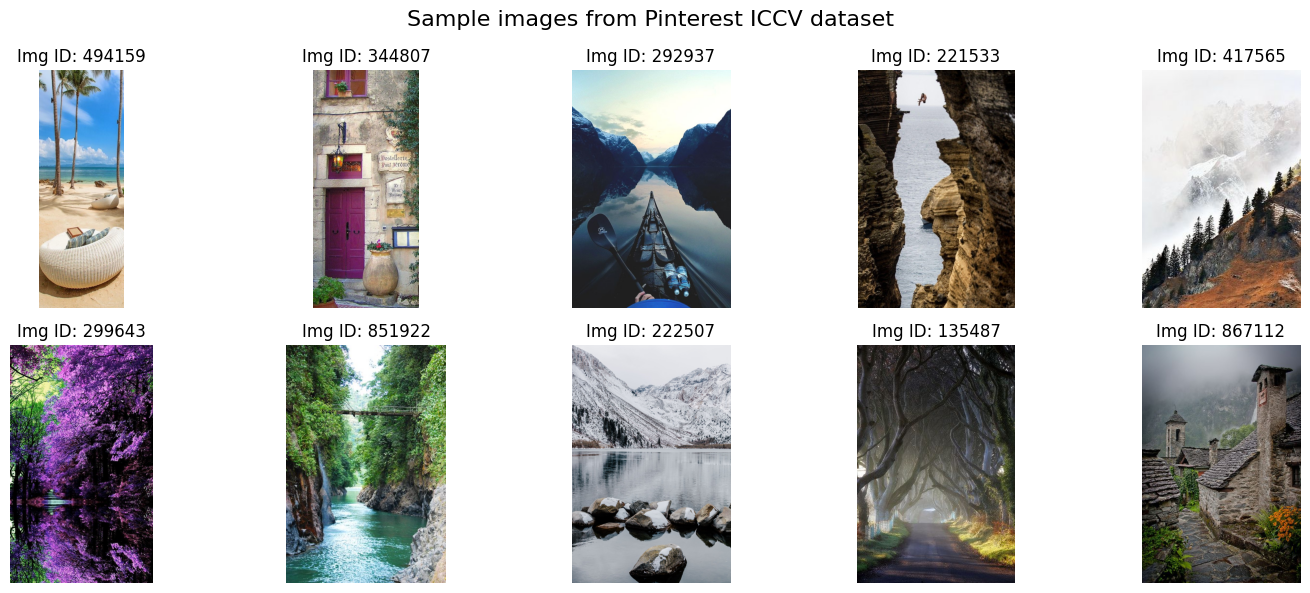

In [ ]:


# Directory where images are stored
image_directory = "/content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_images"  # Replace with the actual directory path

# Filter the DataFrame to get only rows where category_name
india_df = df[df['category_name'] == 'Japan']

# Set a random seed for reproducibility
random.seed(125)

# Get unique img_ids from the filtered DataFrame
img_ids = india_df['img_id'].unique()

selected_img_ids = random.sample(list(img_ids), min(150, len(img_ids)))

# Load and store images
images = []
for img_id in selected_img_ids:
    image_path = os.path.join(image_directory, f"{img_id}.jpg")
    try:
        image = Image.open(image_path)
        images.append((img_id, image))
    except FileNotFoundError:
        # print(f"Image for img_id {img_id} not found.")
        pass

# Plot images in a 2x5 grid
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Sample images from Pinterest ICCV dataset", fontsize=16)

for ax, (img_id, image) in zip(axs.flatten(), images):
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(f"Img ID: {img_id}")

# Hide any unused subplots if there are fewer than 10 images
for ax in axs.flatten()[len(images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


#**Graph Representation**

In [ ]:
!python process_pinterest.py /content/drive/MyDrive/CS_519_Project/CLIPSage/data/pinterest_iccv ./data_processed

In [ ]:
import numpy as np
import dgl
import os
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

out_directory = "/content/drive/MyDrive/CS_519_Project/CLIPSage/data_processed"  # Replace with your actual output directory path
graph_file_path = os.path.join(out_directory, "train_g.bin")
graphs, _ = dgl.load_graphs(graph_file_path)

train_g = graphs[0]  # Assuming there's only one graph saved in the file



In [ ]:
import random


edge_type = ('user', 'interacts', 'item')  # Replace 'interacts' with the actual edge type if different

connections = {}
overlap_ratio = 0.4  # Define how much overlap we want, e.g., 40% of items shared among users

user_node_type = 'user'
item_node_type = 'item'

if user_node_type in train_g.ntypes and item_node_type in train_g.ntypes:
    print("Building connections with overlap between users...")

    all_user_ids = list(range(train_g.num_nodes(user_node_type)))

    random_user_ids = random.sample(all_user_ids, 5)

    common_items = set()

    for user_id in random_user_ids:
        item_connected_nodes = train_g.successors(user_id, etype=edge_type).numpy()  # Get all connected items
        item_connected_nodes = list(item_connected_nodes)

        random.shuffle(item_connected_nodes)

        num_overlap_items = int(len(item_connected_nodes) * overlap_ratio)
        num_unique_items = 5 - num_overlap_items  # Total selected items per user is 5

        overlap_items = random.sample(common_items, min(num_overlap_items, len(common_items)))
        unique_items = item_connected_nodes[:num_unique_items]

        common_items.update(unique_items)

        connections[user_id] = overlap_items + unique_items

# Display the connections dictionary with overlap
print("\nRandom Connections with Overlap Dictionary:")
for user, items in connections.items():
    print(f"User Node {user} is connected to Item Nodes: {items}")


Building connections with overlap between users...

Random Connections with Overlap Dictionary:
User Node 6997 is connected to Item Nodes: [2474944, 2474808, 2474901, 2474820, 2474753, 2474982, 2474947, 2474784, 2474750, 2474751, 2474782, 2474749, 2474806, 2474783, 2474772, 2474799, 2474778, 2474809]
User Node 18798 is connected to Item Nodes: [2474784, 2474901, 2474772, 2474947, 2474799, 2474809, 2474783, 2474753, 2474806, 2474808, 2474944, 2474820, 2474751, 2474982, 780181, 780185, 780155, 780080, 780187, 780173, 780074, 779938, 779942, 780195, 780186, 780176, 780183, 780194, 780189, 780196, 780175, 780152, 779939, 780172, 779941, 779940, 780182, 2553297, 779943, 780159]
User Node 22548 is connected to Item Nodes: [2474809, 2474751, 779939, 780187, 780195, 780183, 2474749, 780194, 780155, 780152, 780189, 780176, 779938, 992278, 992275, 992252, 992315, 992330, 992093, 992283, 992279, 992285, 992282, 992281, 992253, 992094, 992099, 992105, 992289, 992098, 992329, 992095, 992254, 992336

<ipython-input-6-f3d838ff95e9>:30: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  overlap_items = random.sample(common_items, min(num_overlap_items, len(common_items)))


In [ ]:
import plotly.graph_objs as go

# Initialize an empty NetworkX bipartite graph
B = nx.Graph()

user_nodes = [f"user_{user}" for user in connections.keys()]
item_nodes = set()  # Store unique item nodes
for user, items in connections.items():
    user_node = f"user_{user}"
    B.add_node(user_node, bipartite=0)  # User nodes on one side of the bipartite graph
    for item in items[:10]:  # Limit to first 10 items per user
        item_node = f"item_{item}"
        item_nodes.add(item_node)
        B.add_node(item_node, bipartite=1)  # Item nodes on the other side
        B.add_edge(user_node, item_node)  # Create an edge between user and item

# Create layout positions for nodes using bipartite layout
pos = nx.bipartite_layout(B, nodes=user_nodes)

# Separate positions for users and items for plotting
x_user = [pos[node][0] for node in user_nodes]
y_user = [pos[node][1] for node in user_nodes]
x_item = [pos[node][0] for node in item_nodes]
y_item = [pos[node][1] for node in item_nodes]

# Create edge traces
edge_x = []
edge_y = []
for edge in B.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Create user node traces
user_trace = go.Scatter(
    x=x_user, y=y_user,
    mode='markers+text',
    text=user_nodes,
    marker=dict(size=10, color='skyblue'),
    textposition="top center",
    name="User Nodes"
)

# Create item node traces
item_trace = go.Scatter(
    x=x_item, y=y_item,
    mode='markers+text',
    text=list(item_nodes),
    marker=dict(size=10, color='lightgreen'),
    textposition="top center",
    name="Item Nodes"
)

# Create figure and add traces
fig = go.Figure(data=[edge_trace, user_trace, item_trace])

# Set layout for the plot
fig.update_layout(
    title="Interactive Bipartite Graph of Users and Items (20 per User)",
    showlegend=True,
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    hovermode="closest",
    width=800,
    height=600
)

# Display the plot
fig.show()

# **Sample CLIP Embeddings**

In [ ]:
%cd /content/drive/MyDrive/CS_519_Project/CLIPSage

/content/drive/MyDrive/CS_519_Project/CLIPSage


In [ ]:
!python get_clip_emd.py

Chicago Compute?
https://acer.uic.edu/chicago-computes/

#**Training with Pinsage**

In [ ]:
!python model.py data_processed --num-epochs 2 --num-workers 2 --device cuda:0 --hidden-dims 64 --save-dir model_ckpt_with_category_names